In [1]:
import matplotlib.pyplot as plt

# LOAD DATASET
from util.data_loader import load_dataset
x_train, y_train, x_test, feature_names = load_dataset(path_x_train="data/dataset/x_train.csv",
                                                       path_y_train="data/dataset/y_train.csv",
                                                       path_x_test="data/dataset/x_test.csv",
                                                       sub_sample=False)

In [7]:
# REMOVE USELESS FEATURES
from util.features_info import FEATURES_DICT
from util.features_util import keep_features
feature_indexes = dict(zip(feature_names, range(len(feature_names))))
x_clean, clean_features, clean_feature_index = keep_features(x_train, FEATURES_DICT.keys(), feature_names, feature_indexes)

x_test_clean, clean_features, clean_feature_index = keep_features(x_test, FEATURES_DICT.keys(), feature_names, feature_indexes)

Kept 76 features: dict_keys(['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', '_HCVU651', '_CHOLCHK', '_RFCHOL', 'CVDSTRK3', '_ASTHMS1', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', '_DRDXAR1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', '_AGE80', 'MARITAL', '_CHLDCNT', '_EDUCAG', '_INCOMG', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'HTM4', 'WTKG3', '_BMI5', '_SMOKER3', 'USENOW3', 'DRNKANY5', 'DROCDY3_', '_RFBING5', '_DRNKWEK', '_RFDRHV5', 'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', '_FRUTSUM', '_VEGESUM', '_FRTLT1', '_VEGLT1', '_TOTINDA', 'METVL11_', 'METVL21_', 'MAXVO2_', 'ACTIN11_', 'ACTIN21_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', '_MINAC11', '_MINAC21', 'STRFREQ_', 'PA1MIN_', 'PAVIG11_', 'PAVIG21_', 'PA1VIGM_', '_PACAT1', '_PAINDX1', '_PA150R2', '_PA300R2', '_PA30021', '_PASTRNG'])
Kept 76 features: dict_keys(['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PERSDOC2', 'ME

In [8]:
# PREPROCESS KEPT FEATURES
import numpy as np
from util.features_info import REPLACEMENT_LIST
from util.preprocessing import preprocessing_pipeline
x_preprocessed = preprocessing_pipeline(x_clean, 
                                        where=clean_features, 
                                        feature_index=clean_feature_index,
                                        nan_replacement=REPLACEMENT_LIST)

x_test_preprocessed = preprocessing_pipeline(x_test_clean, 
                                             where=clean_features, 
                                             feature_index=clean_feature_index, 
                                             nan_replacement=REPLACEMENT_LIST)

In [9]:
# Split train-validation
from util.data_loader import split_train_validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_preprocessed, y_train, valid_proportion=0.2)

In [43]:
# oversample training set
from util.data_loader import custom_random_oversampling
x_tr_oversampled, y_tr_oversampled = custom_random_oversampling(x_tr, y_tr[:,1])

In [6]:
import numpy as np

def min_max_normalize(arr: np.ndarray):
    arr_normalized = np.empty_like(arr)
    for column in range(arr.shape[1]):
        arr_normalized[:, column] = (arr[:, column] - arr[:, column].min()) / (arr[:, column].max() - arr[:, column].min())
    return arr_normalized

In [44]:
# Normalize and add bias column for TRAINING
x_tr_normalized = min_max_normalize(x_tr_oversampled)
x_tr_normalized = np.append(x_tr_normalized, np.ones(shape=(x_tr_normalized.shape[0], 1)), axis=1)

# Normalize and add bias column for VALIDATION
x_va_normalized = min_max_normalize(x_va)
x_va_normalized = np.append(x_va_normalized, np.ones(shape=(x_va_normalized.shape[0], 1)), axis=1)

# Normalize and add bias column for TEST
x_test_normalized = min_max_normalize(x_test)
x_test_normalized = np.append(x_test_normalized, np.ones(shape=(x_test_normalized.shape[0], 1)), axis=1)



In [136]:
from util.train import reg_logistic_regression
import numpy as np
w, train_loss, valid_loss = reg_logistic_regression(x_tr_normalized, y_tr_oversampled, 
                                                    x_va_normalized, y_va[:,1], lambda_=0.0001, 
                                                    max_iter=5000, gamma=0.001, batch_size=100, 
                                                    w=np.random.random(size=x_tr_normalized.shape[1]))


100%|██████████| 5000/5000 [02:10<00:00, 38.19it/s]


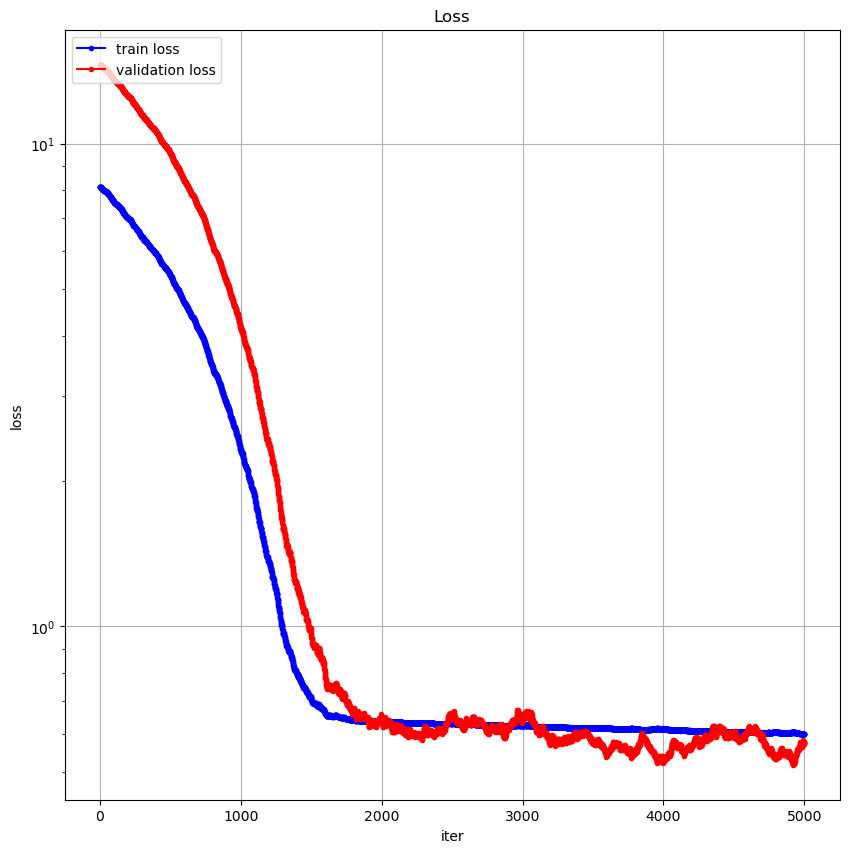

In [137]:
# plot losses
import matplotlib.pyplot as plt
from util.plotting import loss_visualization
plt.figure(figsize=(10, 10))
loss_visualization(train_loss, valid_loss)
plt.yscale("log")

In [138]:
from implementations import sigmoid
from util.evaluation import evaluation_summary
x_tr_predictions = np.where(sigmoid(x_tr_normalized @ w) >= 0.5, 1, -1)

evaluation_summary(y_tr_oversampled, x_tr_predictions)

Accuracy: 68.15%
Precision: 70.04%
Recall: 61.54%
F1-score: 65.52%


(array([10641., 55623., 74537., 72956., 62883., 53496., 46866., 41018.,
        35061., 17849.]),
 array([0.03839826, 0.13373481, 0.22907135, 0.3244079 , 0.41974444,
        0.51508098, 0.61041753, 0.70575407, 0.80109062, 0.89642716,
        0.99176371]),
 <BarContainer object of 10 artists>)

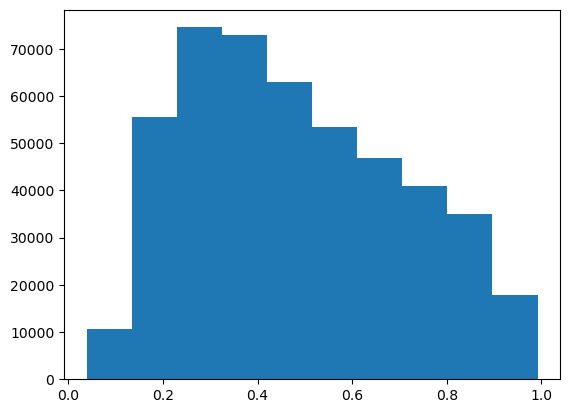

In [139]:
plt.hist(sigmoid(x_tr_normalized @ w))

(array([ 3389., 11941., 13299., 11097.,  8416.,  6339.,  4625.,  3284.,
         2348.,   889.]),
 array([0.04942038, 0.14355041, 0.23768043, 0.33181046, 0.42594049,
        0.52007051, 0.61420054, 0.70833056, 0.80246059, 0.89659061,
        0.99072064]),
 <BarContainer object of 10 artists>)

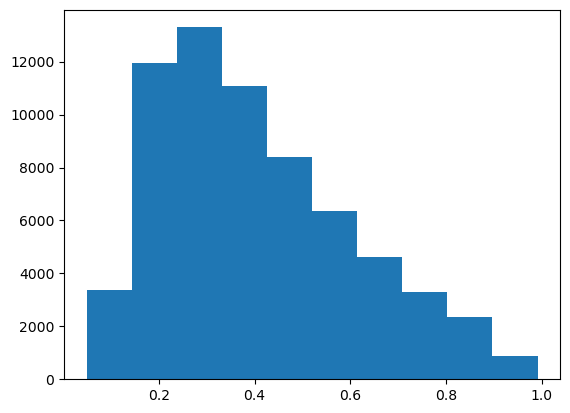

In [140]:
plt.hist(sigmoid(x_va_normalized @ w))

In [146]:
x_valid_pred = np.where(sigmoid(x_va_normalized @ w) >= 0.5, 1, -1)

evaluation_summary(y_va[:,1], x_valid_pred)

Accuracy: 72.91%
Precision: 18.64%
Recall: 61.10%
F1-score: 28.56%


In [44]:
x_test_predictions = np.where(sigmoid(x_test_normalized @ w) >= 0.7, 1, -1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 77 is different from 323)